# First Clifford Experiment

### Description
This notebook demonstrates a simple experiment for analyzing quantum noises.<br>
In the experiment, we will run a simple circuit on both _qasm simulator_ and _clifford simulator_ with different noise parameters (_pauli_).

##### Circuit Description
The circuit we will use contains 3 qubits and on each qubit an _id_ gate is placed, in addition measurement gates is placed on all qubits at the end of the circuit.
![title](images/first_clifford_experiment.png)

##### Specifics
For each run of the simulator we get a vector of lenght 8 (because we have 3 qubits) which contains the measurements results.

First we will normalize the vector by divide its values by number of shots.
Then we will multiply the vector by its transpose to create a covariance matrix.

Given the _exact covariance matrix_ and _clifford covariance matrix_ resulted from running the exact and clifford simulator with the same noise parameters, we will calculate the Frobenius norm of the matrices difference.

### imports and function defenitions

In [1]:
import sys
import numpy as np
sys.path.append("../")
import qiskit.backends.local.qasm_simulator_cpp as qs
SIM_EXECUTABLE = '../out/src/qasm-simulator-cpp/qasm_simulator_cpp'

def generate_counts_vec(sim_output):
    """Returns ndarray of length 8 which contains result counts devided by shots_num"""
    vec = np.zeros(8, dtype=int)
    for i, count in sim_output['result'][0]['data']['counts'].items():
        vec[int(i, 2)] = count
        
    return vec[np.newaxis] / sim_output['result'][0]['shots']

def run(qobj):
    """
    Runs both simulators (noise params should be already set in qobj)
    Then compute the norm.
    """

    # run exact simulator
    qobj['config']['backend'] = 'local_qasm_simulator_cpp'
    exact_vec = generate_counts_vec(qs.run(qobj, SIM_EXECUTABLE))
    
    # run clifford simulator
    qobj['config']['backend'] = 'local_clifford_simulator_cpp'
    qobj['config']['noise_params'] = {}
    qobj['config']['noise_params']['id'] = {}
    clifford_vec = generate_counts_vec(qs.run(qobj, SIM_EXECUTABLE))
    
    exact_matrix = exact_vec.T * exact_vec
    clifford_matrix = clifford_vec.T * clifford_vec
    
    return np.linalg.norm(exact_matrix - clifford_matrix)


### qobj definition

In [2]:
qobj = {
  "id": "First Clifford Experiment",
  "config": {
      "noise_params": {
        "id": {"p_pauli": [0, 0, 0]}
      },
      "shots": 1024,
      "seed": 412
  },
  "circuits": [
    {
      "compiled_circuit": {
        "header": {
                    "number_of_clbits": 3,
                    "number_of_qubits": 3,
                    "clbit_labels": [["c", 3]],
                    "qubit_labels": [["q", 0], ["q", 1], ["q", 2]]
                },
        "operations": [
                    {"name": "id", "qubits": [0]},
                    {"name": "id", "qubits": [1]},
                    {"name": "id", "qubits": [2]},
                    {"name": "measure", "qubits": [0], "clbits": [0]},
                    {"name": "measure", "qubits": [1], "clbits": [1]},
                    {"name": "measure", "qubits": [2], "clbits": [2]}
                ]
      }
    }
  ]
}


### Running the experiment

In [3]:
x_noises = []
y_noises = []
z_noises = []
single_axis_noise_params = np.linspace(0, 1, num=100, dtype=float)
for p in single_axis_noise_params:
    # run circuit with noises on x axis
    qobj['config']['noise_params']['id']['p_pauli'] = [p, 0, 0]
    x_noises.append(run(qobj))
    
    # run circuit with noises on y axis
    qobj['config']['noise_params']['id']['p_pauli'] = [0, p, 0]
    y_noises.append(run(qobj))
    
    # run circuit with noises on z axis
    qobj['config']['noise_params']['id']['p_pauli'] = [0, 0, p]
    z_noises.append(run(qobj))


### Plot the results

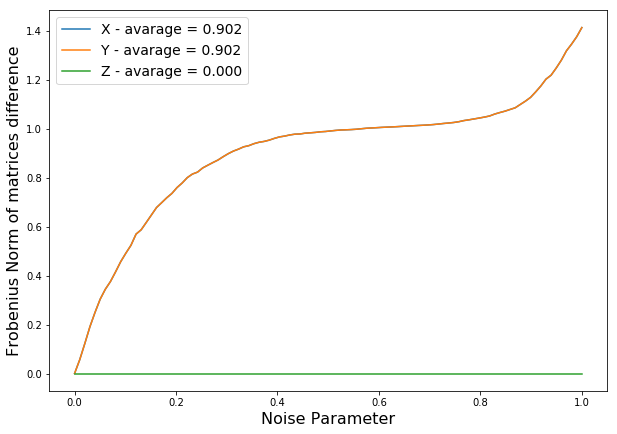

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
x_legend = 'X - avarage = %.3f' % (sum(x_noises) / len(x_noises))
y_legend = 'Y - avarage = %.3f' % (sum(y_noises) / len(y_noises))
z_legend = 'Z - avarage = %.3f' % (sum(z_noises) / len(z_noises))

plt.rcParams['figure.figsize'] = [10, 7]

plt.plot(single_axis_noise_params, x_noises)
plt.plot(single_axis_noise_params, y_noises)
plt.plot(single_axis_noise_params, z_noises)

plt.legend([x_legend, y_legend, z_legend], loc='best', prop={'size': 14})
plt.xlabel('Noise Parameter', fontsize=16)
plt.ylabel('Frobenius Norm of matrices difference', fontsize=16)
pass